using:
    
    Riddhi_SLAM/20181008-concatenated_labels.npz

In [1]:
MAXMSMT = 300

In [2]:
import numpy as np
import matplotlib

fsize=8
Fsize=8
# Set global parameters
matplotlib.rcParams['font.size'] = fsize # global
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['mathtext.default'] ='regular' # makes mathtext mode Arial. note mathtext is used as ticklabel font in log plots

# Set global tick mark parameters
matplotlib.rcParams['xtick.major.width'] = 0.5
matplotlib.rcParams['ytick.major.width'] = 0.5
matplotlib.rcParams['xtick.labelsize']= fsize
matplotlib.rcParams['ytick.labelsize'] = fsize
matplotlib.rcParams['xtick.minor.visible'] = False
matplotlib.rcParams['ytick.minor.visible'] = False
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'


import sys
sys.path.append('../') # where to find qslam folder
import copy
## import qslam modules

from exptrisk import EmpiricalRisk
from qslamdesignparams import GLOBALDICT 
import matplotlib.pyplot as plt
from visualiserisk import DataCube, cm2inch

/home/riddhisw/Documents/SLAM_project/qslam/expt_data/Riddhi_SLAM/20181008-concatenated_labels.npz


In [3]:
num_qubits = 5 # number of ions in the trap

In [4]:
change_gridconfig = True

# assume equi-distant linear array
if change_gridconfig is True:
    GLOBALDICT["GRIDDICT"] = {}
    for idx_posy in range(num_qubits):
        if idx_posy < 10 :
            GLOBALDICT["GRIDDICT"]["QUBIT_0" + str(idx_posy)] = (0.0, float(idx_posy))
        if idx_posy >= 10 :
            GLOBALDICT["GRIDDICT"]["QUBIT_" + str(idx_posy)] = (0.0, float(idx_posy))

In [5]:
change_MAX_NUM_ITERATIONS = 5
change_MSMTS_PER_NODE = 1
change_SIGMOID_APPROX_ERROR = 10.0**(-6)
change_QUANTISATION_UNCERTY = 10.0**(-4)
change_P_ALPHA = 15 
change_P_BETA = 10 
change_LAMBDA_1 = 0.820
change_LAMBDA_2 = 0.968

GLOBALDICT["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = 5
GLOBALDICT["MODELDESIGN"]["MSMTS_PER_NODE"] = 1
GLOBALDICT["NOISEPARAMS"]["SIGMOID_APPROX_ERROR"]["SIGMA"] = change_SIGMOID_APPROX_ERROR
GLOBALDICT["NOISEPARAMS"]["QUANTISATION_UNCERTY"]["SIGMA"] = change_QUANTISATION_UNCERTY
GLOBALDICT["MODELDESIGN"]["P_ALPHA"] = change_P_ALPHA
GLOBALDICT["MODELDESIGN"]["P_BETA"] = change_P_BETA
GLOBALDICT["MODELDESIGN"]["LAMBDA_1"] = change_LAMBDA_1
GLOBALDICT["MODELDESIGN"]["LAMBDA_2"] = change_LAMBDA_2

In [6]:
meta_max_iter_scan = [ 5, 10, 15, 20, 25, 50, 75, 100, 125, 250]

lambda1 = [0.99, 0.956, 0.922, 0.888, 0.854, 0.820, 0.786, 0.752, 0.718, 0.684, 0.65]
lambda2 = [0.977, 0.9752, 0.9734, 0.9716, 0.9698, 0.968, 0.9662, 0.9644, 0.9626, 0.9608, 0.959]
lambda_scan = zip(lambda1, lambda2)

msmt_per_qubit_scan = [1, 2, 4, 5, 6, 8, 10, 15, 20, 25, 50]


LOOPS_DICT = {"meta_max_iter_scan":meta_max_iter_scan, 
              "lambda_scan":lambda_scan,
              "msmt_per_qubit_scan": msmt_per_qubit_scan}

ParamUpdater = DataCube(LOOPS_DICT)


Using %s lambda ... (0.99, 0.977)


../particlesets.py:162: RuntimeWarning: overflow encountered in double_scalars
  normalisation = 1.0/unnormalised_total
../particlesets.py:163: RuntimeWarning: invalid value encountered in multiply
  return normalisation*raw_weights



Using %s lambda ... (0.956, 0.9752)

Using %s lambda ... (0.922, 0.9734)

Using %s lambda ... (0.888, 0.9716)

Using %s lambda ... (0.854, 0.9698)

Using %s lambda ... (0.82, 0.968)

Using %s lambda ... (0.786, 0.9662)

Using %s lambda ... (0.752, 0.9644)

Using %s lambda ... (0.718, 0.9626)

Using %s lambda ... (0.684, 0.9608)

Using %s lambda ... (0.65, 0.959)


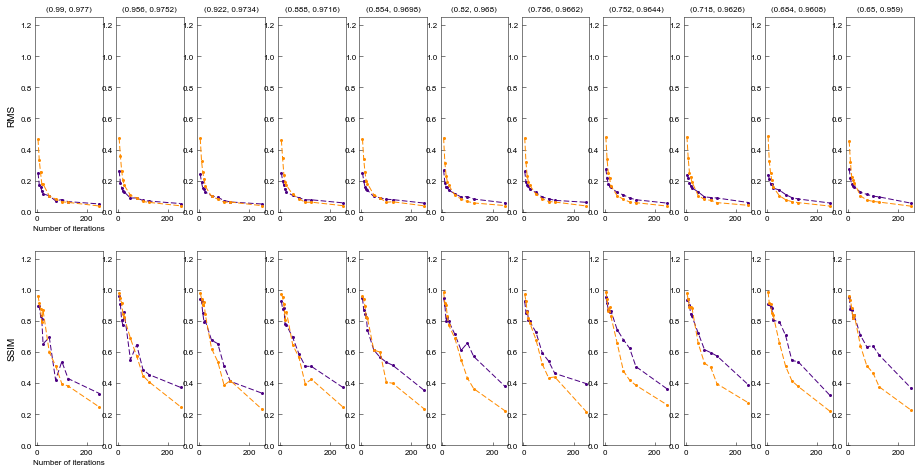

In [7]:
SAMPLE_GLOBAL_MODEL = copy.deepcopy(GLOBALDICT)

meta_ssim_pairs_1 = []
meta_empr_pairs_1 = []

fig = plt.figure( figsize=(cm2inch(40), cm2inch(20)))

for idx_msmtpernode in range(len(ParamUpdater.lambda_scan)):
    
    print
    print "Using %s lambda ...", ParamUpdater.lambda_scan[idx_msmtpernode]

    SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["LAMBDA_1"] = ParamUpdater.lambda_scan[idx_msmtpernode][0]
    SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["LAMBDA_2"] = ParamUpdater.lambda_scan[idx_msmtpernode][1]
    
    ssim_qslam = []
    err_qslam = []
    err_naive =[]
    ssim_naive =[]
    
    for idx_msmt_iter in range(len(ParamUpdater.meta_max_iter_scan)):
    
        SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = ParamUpdater.meta_max_iter_scan[idx_msmt_iter]
        
        expt = EmpiricalRisk(SAMPLE_GLOBAL_MODEL)
        err, ssim = expt.calculate_risk(number_of_trials=50)
        
        ssim_qslam.append(ssim[0])
        err_qslam.append(err[0])
        
        ssim_naive.append(ssim[1])
        err_naive.append(err[1])
    
    ax = fig.add_subplot(2, len(ParamUpdater.lambda_scan), len(ParamUpdater.lambda_scan)  + idx_msmtpernode + 1)
    #ax.set_title(ParamUpdater.lambda_scan[idx_msmtpernode],fontsize=fsize)
    ax.plot(ParamUpdater.meta_max_iter_scan, ssim_qslam, 'o--', lw=1.0, ms=2., c='indigo')
    ax.plot(ParamUpdater.meta_max_iter_scan, ssim_naive, 'o--', lw=1.0, ms=2., c='darkorange')
    ax.set_ylim([0, 1.25])
    if idx_msmtpernode ==0:
        ax.set_xlabel('Number of iterations',fontsize=fsize)
        ax.set_ylabel('SSIM')
    
    ax = fig.add_subplot(2, len(ParamUpdater.lambda_scan), idx_msmtpernode + 1)
    ax.set_title(ParamUpdater.lambda_scan[idx_msmtpernode],fontsize=fsize)
    ax.plot(ParamUpdater.meta_max_iter_scan, err_qslam, 'o--', lw=1.0, ms=2., c='indigo')
    ax.plot(ParamUpdater.meta_max_iter_scan, err_naive, 'o--', lw=1.0, ms=2., c='darkorange')
    ax.set_ylim([0, 1.25])
    if idx_msmtpernode ==0:
        ax.set_xlabel('Number of iterations',fontsize=fsize)
        ax.set_ylabel('RMS')
    
    
    meta_ssim_pairs_1.append([ssim_qslam, ssim_naive])
    meta_empr_pairs_1.append([err_qslam, err_naive])
    
    np.savez('qslam_Ramseys_pA_v1_lambdascan', 
             ParamUpdater=ParamUpdater, 
             meta_ssim_pairs=meta_ssim_pairs_1, 
             meta_empr_pairs=meta_empr_pairs_1)
    
plt.show()

#### Plot Perf. Score vs. Weighting Ratio
(as num of iterations increase left to right)

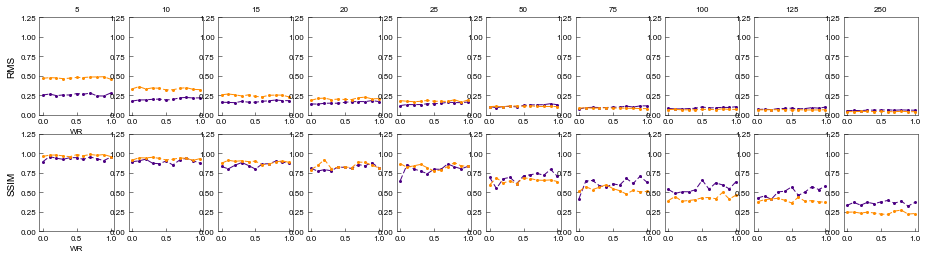

In [8]:
xaxis = np.linspace(0, 1, len(ParamUpdater.lambda_scan))
qslam=0
naive=1
data  = np.load('qslam_Ramseys_pA_v1_lambdascan.npz')

fig = plt.figure( figsize=(cm2inch(40), cm2inch(10)))

for idx_iter in range(len(ParamUpdater.meta_max_iter_scan)):
    
    ax = fig.add_subplot(2, len(ParamUpdater.meta_max_iter_scan), idx_iter + 1)
    ax.set_title(ParamUpdater.meta_max_iter_scan[idx_iter],fontsize=fsize)
    ax.plot(xaxis, data["meta_empr_pairs"][:, qslam, idx_iter], 'o--', lw=1.0, ms=2., c='indigo')
    ax.plot(xaxis, data["meta_empr_pairs"][:, naive, idx_iter], 'o--', lw=1.0, ms=2., c='darkorange')
    ax.set_ylim([0, 1.25])
    if idx_iter ==0:
        ax.set_xlabel('WR',fontsize=fsize)
        ax.set_ylabel('RMS')
    
    ax = fig.add_subplot(2, len(ParamUpdater.meta_max_iter_scan), len(ParamUpdater.meta_max_iter_scan) + idx_iter + 1)
    #ax.set_title(ParamUpdater.lambda_scan[idx_msmtpernode],fontsize=fsize)
    ax.plot(xaxis, data["meta_ssim_pairs"][:, qslam, idx_iter], 'o--', lw=1.0, ms=2., c='indigo')
    ax.plot(xaxis, data["meta_ssim_pairs"][:, naive, idx_iter], 'o--', lw=1.0, ms=2., c='darkorange')
    ax.set_ylim([0, 1.25])
    if idx_iter ==0:
        ax.set_xlabel('WR',fontsize=fsize)
        ax.set_ylabel('SSIM')

plt.show()